### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.tabular.all import *
from fastbook import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

from dtreeviz.trees import *
import dtreeviz

from IPython.display import Image, display_svg, SVG

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
df['CryoSleep'].isnull().count

<bound method Series.count of 0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689    False
8690    False
8691    False
8692    False
Name: CryoSleep, Length: 8693, dtype: bool>

In [12]:
df[np.where(df['CryoSleep'] == True, True, False)].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
18,0016_01,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Almary Brantuarez,False


In [13]:
df[np.where(df['CryoSleep'] == True, True, False)].shape

(3037, 14)

In [14]:
cryo_amenities_df = ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [115]:
null_cryo_df = df.loc[df['CryoSleep'].isnull(), cryo_amenities_df]
test_null_cryo_df = test_df.loc[df['CryoSleep'].isnull(), cryo_amenities_df]

In [16]:
df['CryoSleep'].isnull().sum()

217

In [17]:
null_cryo_df

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
92,NaN,0.0,0.0,0.0,0.0,0.0
98,NaN,0.0,0.0,570.0,2.0,131.0
104,NaN,0.0,331.0,0.0,0.0,1687.0
111,NaN,0.0,0.0,0.0,0.0,NaN
152,NaN,0.0,985.0,0.0,5.0,0.0
...,...,...,...,...,...,...
8620,NaN,0.0,0.0,0.0,0.0,0.0
8651,NaN,0.0,0.0,0.0,0.0,0.0
8664,NaN,0.0,0.0,0.0,0.0,0.0
8675,NaN,1030.0,1015.0,0.0,11.0,NaN


here

In [18]:
amenities_mask =(null_cryo_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] > 0).any(axis=1)
amenities_mask

92      False
98       True
104      True
111     False
152      True
        ...  
8620    False
8651    False
8664    False
8675     True
8687     True
Length: 217, dtype: bool

In [19]:
# null_cryo_df['CyroSleep'] = np.where(amenities_mask, False, True)

In [20]:
df.loc[null_cryo_df.index, cryo_amenities_df].head(), df.loc[null_cryo_df.index, cryo_amenities_df].shape

(    CryoSleep  RoomService  FoodCourt  ShoppingMall  Spa  VRDeck
 92        NaN          0.0        0.0           0.0  0.0     0.0
 98        NaN          0.0        0.0         570.0  2.0   131.0
 104       NaN          0.0      331.0           0.0  0.0  1687.0
 111       NaN          0.0        0.0           0.0  0.0     NaN
 152       NaN          0.0      985.0           0.0  5.0     0.0,
 (217, 6))

In [21]:
df.loc[null_cryo_df.index, 'CryoSleep']

92      NaN
98      NaN
104     NaN
111     NaN
152     NaN
       ... 
8620    NaN
8651    NaN
8664    NaN
8675    NaN
8687    NaN
Name: CryoSleep, Length: 217, dtype: object

In [22]:
df.loc[null_cryo_df.index, 'CryoSleep'] = np.where(amenities_mask, False, True)

In [23]:
df['CryoSleep'].isnull().sum()

0

In [24]:
df['RoomService'].isnull().sum()

181

In [25]:
test_df.shape

(4277, 13)

In [26]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [27]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isnull().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [28]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [29]:
df[amenities] = df[amenities].fillna(0)

This name on such a small dataset could cause overfitting, so I'm going to try splitting into families by last name. I'll also be dropping `Name` as a category afterward

In [30]:
df['surname'] = df['Name'].str.split(' ').str[1]

In [31]:
test_df['surname'] = test_df['Name'].str.split(' ').str[1]

In [32]:
df = df.drop(['Name'], axis=1)

In [33]:
test_df = test_df.drop(['Name'], axis=1)

Looking at this there's some extra data we can extract to new columns, *PassengerId* looks like it's by group number and the number in a particular group, split with an underscore `_` 

In [34]:
df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['num_w_in_group'] = df['PassengerId'].str.split('_').str[1]

In [35]:
test_df['group_num'] =test_df['PassengerId'].str.split('_').str[0]
test_df['num_w_in_group'] =test_df['PassengerId'].str.split('_').str[1]

The same is true for the Cabin, there are 3 different values to analyze here, so let's split them up as well

In [36]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['room_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [37]:
test_df['deck'] = test_df['Cabin'].str.split('/').str[0]
test_df['room_num'] = test_df['Cabin'].str.split('/').str[1]
test_df['side'] = test_df['Cabin'].str.split('/').str[2]

Take the max number of the last two digits in PassengerId given that the first four numbers are the same

In [38]:
df['num_w_in_group'] = df['num_w_in_group'].astype(int)

In [39]:
test_df['num_w_in_group'] = test_df['num_w_in_group'].astype(int)

In [40]:
max_num_in_group = df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [41]:
test_max_num_in_group = test_df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [42]:
len(max_num_in_group)

6217

In [43]:
max_num_in_group.head()

group_num
0001    1
0002    1
0003    2
0004    1
0005    1
Name: num_w_in_group, dtype: int64

In [44]:
df['num_in_group'] = df['group_num'].map(max_num_in_group)

In [45]:
test_df['num_in_group'] = test_df['group_num'].map(test_max_num_in_group)

In [46]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1


Finding if everyone boarding is a family group or not by last name:
- Find if the count of family group == num_in_group

In [47]:
boarded_together = df.groupby('surname')['num_in_group'].nunique() == 1

In [48]:
test_boarded_together = test_df.groupby('surname')['num_in_group'].nunique() == 1

In [49]:
df['fam_board_together'] = df['surname'].map(boarded_together)

In [50]:
test_df['fam_board_together'] = test_df['surname'].map(test_boarded_together)

In [51]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1,False


In [52]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Carsoning,0013,1,G,3,S,1,False
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Peckers,0018,1,F,4,S,1,True
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Unhearfus,0019,1,C,0,S,1,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Caltilter,0021,1,C,1,S,1,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Harperez,0023,1,F,5,S,1,True


In [53]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Transported'")
    return null_count_df

null_= get_null_counts(df)
null_.style.background_gradient(cmap='summer')

,column_name,null_counts
0,VIP,203
1,HomePlanet,201
2,fam_board_together,200
3,surname,200
4,Cabin,199
5,side,199
6,room_num,199
7,deck,199
8,Destination,182
9,Age,179


In [54]:
test_null = get_null_counts(test_df)
null_.style.background_gradient(cmap='winter')

,column_name,null_counts
0,VIP,203
1,HomePlanet,201
2,fam_board_together,200
3,surname,200
4,Cabin,199
5,side,199
6,room_num,199
7,deck,199
8,Destination,182
9,Age,179


Boolean values converted to 0's and 1's

In [55]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [56]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')
bool_switch(df, col_name="fam_board_together")

In [57]:
df.shape

(8693, 21)

In [58]:
bool_switch(test_df, col_name='VIP')
bool_switch(test_df, col_name='CryoSleep')
bool_switch(test_df, col_name="fam_board_together")

In [59]:
test_df.shape

(4277, 20)

### Preparing Data

Declare dependant variable(y-axis)

In [60]:
#| export
dep_var = 'Transported'

In [61]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [62]:
#| export
procs = [Categorify, FillMissing, Normalize]

In [63]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [64]:
test_cont, test_cat = cont_cat_split(test_df, 1, dep_var=dep_var)

In [65]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, 
                    y_block=CategoryBlock(), 
                    splits=RandomSplitter(valid_pct=0.2, seed=42)(df)).dataloaders(bs=128)

In [66]:
to.fill_strategy

'median'

In [67]:
test_to = TabularPandas(test_df, procs, test_cat, test_cont, y_names=None, 
                    y_block=CategoryBlock(), 
                    splits=None).dataloaders(bs=128)

In [68]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [69]:
test_xs = test_to.train.xs

In [70]:
xs.head()

,PassengerId,HomePlanet,Cabin,Destination,surname,group_num,deck,room_num,side,Age_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_w_in_group,num_in_group,fam_board_together
8388,8389,3,3242,3,300,6005,6,786,2,1,-0.759434,1.612332,-0.206029,1.470626,-0.282769,-0.267182,-0.267988,-0.263122,-0.493406,-0.652869,1.123458
1917,1918,1,5560,3,0,1362,7,1078,1,1,1.316770,-0.265485,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,1.383858,2.463179,2.994542
5173,5174,1,6379,2,1504,3719,7,1692,1,1,-0.759434,0.012710,-0.206029,-0.327109,-0.284032,-0.246835,-0.267988,0.100366,-0.493406,-0.652869,1.123458
8246,8247,1,2091,2,870,5905,5,1351,2,1,-0.759434,2.377369,-0.206029,-0.327109,-0.284032,-0.145103,-0.267988,1.836428,-0.493406,-0.652869,1.123458
61,62,1,4563,2,1186,44,7,3,2,1,1.316770,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,-0.493406,0.593550,-0.747627


In [71]:
xs.shape

(6955, 21)

In [72]:
test_xs.head()

,PassengerId,HomePlanet,Cabin,Destination,surname,group_num,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_w_in_group,num_in_group,fam_board_together
0,1,1,2785,3,276,1,7,821,2,1,1,1,1,1,1,1.116736,-0.114147,-0.191678,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-0.489847,-0.648973,-1.116345
1,2,1,1868,3,1191,2,6,928,2,1,1,1,1,1,1,-0.758521,-0.684313,-0.191678,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,-0.489847,-0.648973,0.757520
2,3,2,258,1,1605,3,3,1,2,1,1,1,1,1,1,1.116736,0.170937,-0.191678,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-0.489847,-0.648973,0.757520
3,4,2,260,3,263,4,3,2,2,1,1,1,1,1,1,-0.758521,0.669832,-0.191678,-0.357339,4.121518,-0.312173,-0.104002,0.226648,-0.489847,-0.648973,0.757520
4,5,1,1941,3,737,5,6,1030,2,1,1,1,1,1,1,-0.758521,-0.613042,-0.191678,-0.340723,-0.283840,0.832122,-0.267841,-0.246712,-0.489847,-0.648973,0.757520


In [73]:
test_xs.shape

(4277, 26)

/tmp/ipykernel_10211/3888966817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

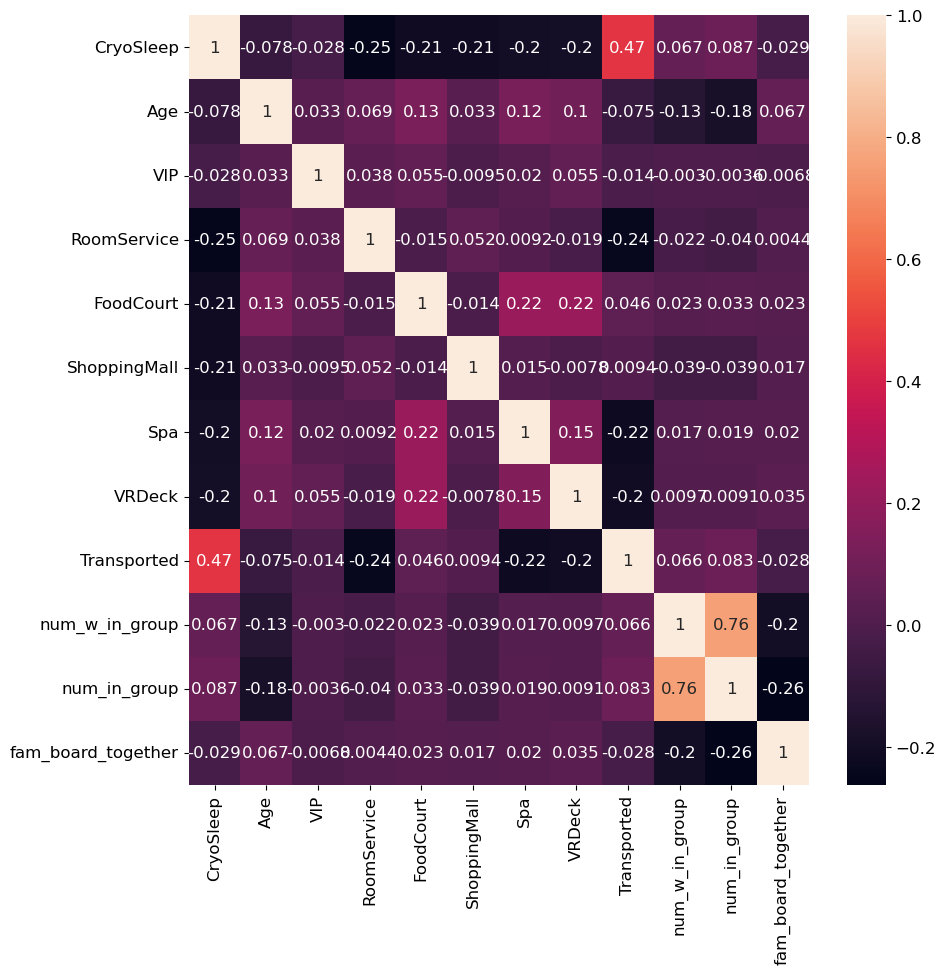

In [74]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [75]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [76]:
m = rf(xs,y)

In [77]:
def pred_acc(m, valid_xs=valid_xs):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy

In [78]:
pred_acc(m)

0.8084004602991944

In [79]:
def rf_feat_importances(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [80]:
fi = rf_feat_importances(m, xs)
fi

,cols,imp
10,CryoSleep,0.197143
13,RoomService,0.095938
16,Spa,0.091649
17,VRDeck,0.080603
14,FoodCourt,0.074982
2,Cabin,0.073193
11,Age,0.057563
15,ShoppingMall,0.044536
7,room_num,0.044188
4,surname,0.043897


In [81]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot: ylabel='cols'>

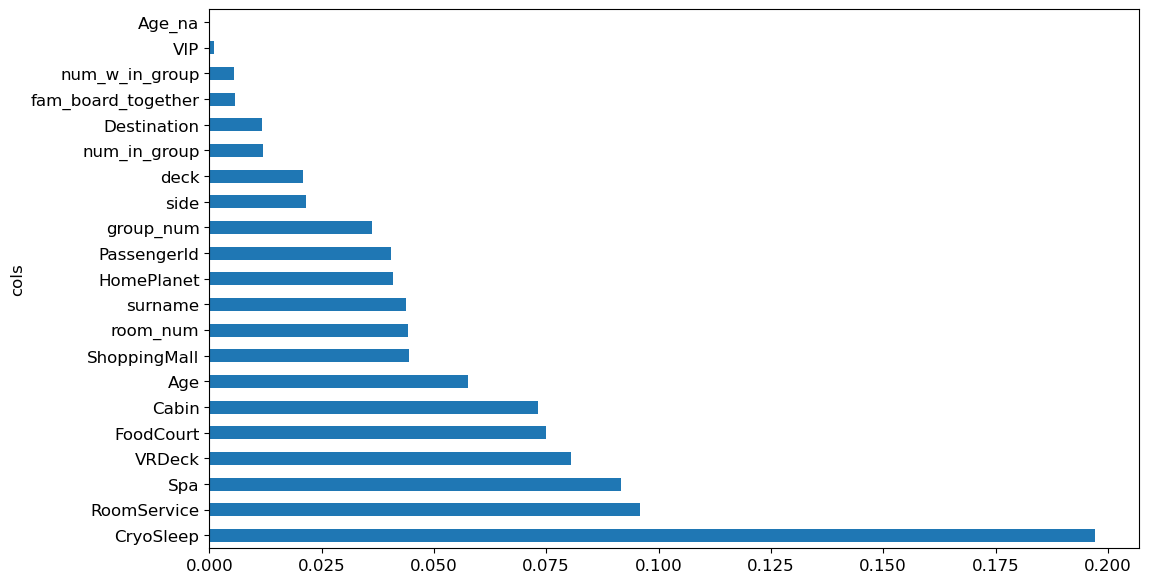

In [82]:
plot_fi(fi)

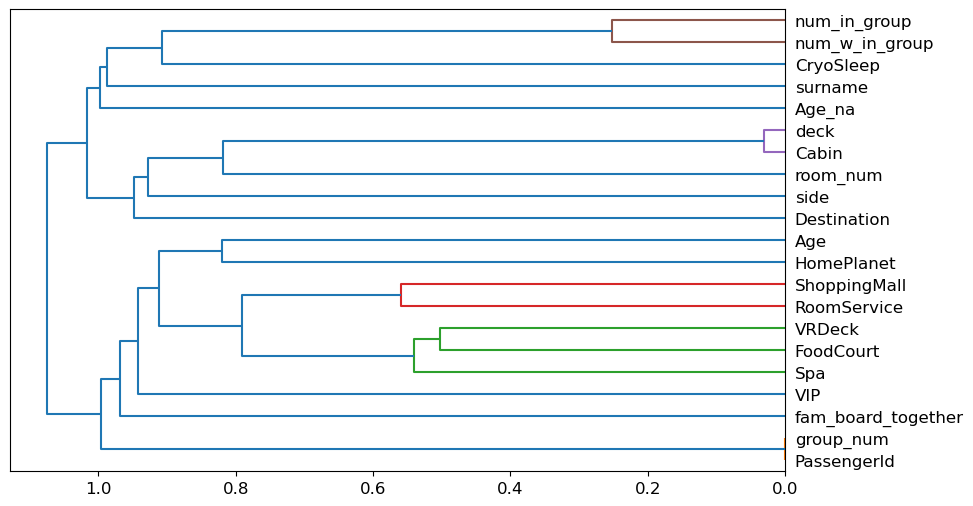

In [83]:
cluster_columns(xs)

In [84]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep), len(fi)

(19, 21)

In [85]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [86]:
test_xs_imp = test_xs[to_keep]

In [87]:
len(test_xs_imp)

4277

In [88]:
m = rf(xs_imp, y)

In [89]:
pred_acc(m, valid_xs=valid_xs_imp)

0.8135788262370541

<AxesSubplot: ylabel='cols'>

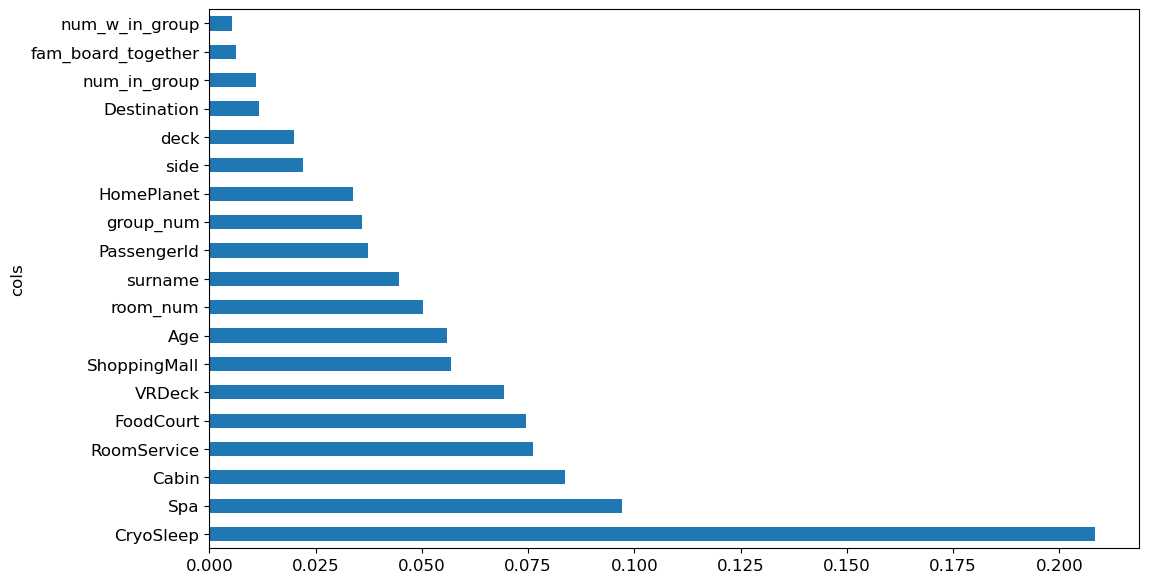

In [90]:
plot_fi(rf_feat_importances(m, xs_imp))

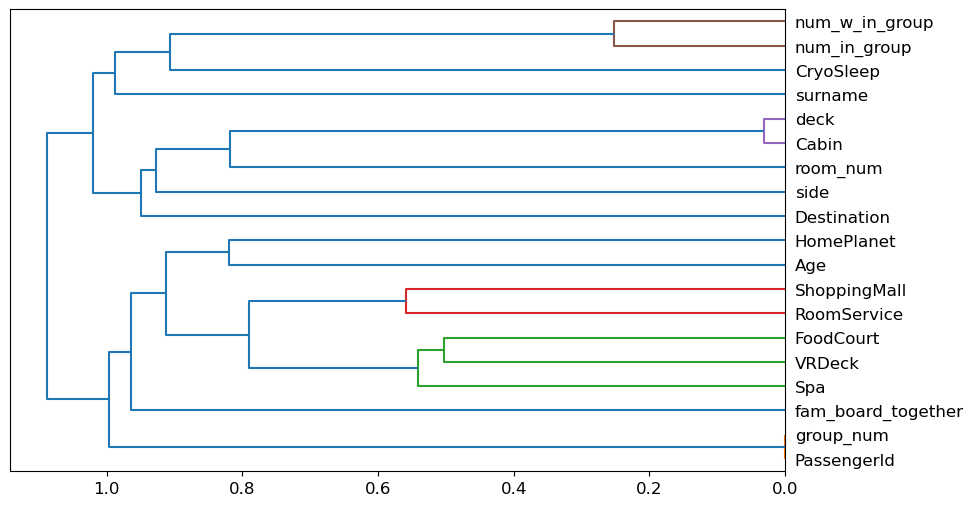

In [91]:
cluster_columns(xs_imp)

In [92]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [93]:
get_oob(xs_imp)


0.7923795830337886

In [94]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in xs_imp.columns}

{'CryoSleep': 0.7903666427030913,
 'RoomService': 0.7949676491732567,
 'Spa': 0.7780014378145219,
 'VRDeck': 0.7807332854061826,
 'FoodCourt': 0.7923795830337886,
 'Cabin': 0.797411933860532,
 'Age': 0.7952552120776419,
 'ShoppingMall': 0.7920920201294033,
 'room_num': 0.7923795830337886,
 'surname': 0.7971243709561466,
 'HomePlanet': 0.794823867721064,
 'PassengerId': 0.792235801581596,
 'group_num': 0.7955427749820273,
 'side': 0.794823867721064,
 'deck': 0.7981308411214953,
 'num_in_group': 0.7985621854780733,
 'Destination': 0.7985621854780733,
 'fam_board_together': 0.7949676491732567,
 'num_w_in_group': 0.793961179007908}

In [95]:
{c:get_oob(xs.drop(c, axis=1)) for c in xs.columns}

{'PassengerId': 0.7971243709561466,
 'HomePlanet': 0.796980589503954,
 'Cabin': 0.796980589503954,
 'Destination': 0.7972681524083394,
 'surname': 0.7916606757728253,
 'group_num': 0.7971243709561466,
 'deck': 0.7959741193386053,
 'room_num': 0.7919482386772106,
 'side': 0.7913731128684399,
 'Age_na': 0.7972681524083394,
 'CryoSleep': 0.793961179007908,
 'Age': 0.7916606757728253,
 'VIP': 0.7964054636951833,
 'RoomService': 0.7897915168943206,
 'FoodCourt': 0.7907979870596693,
 'ShoppingMall': 0.7906542056074767,
 'Spa': 0.7827462257368799,
 'VRDeck': 0.7850467289719626,
 'num_w_in_group': 0.7958303378864127,
 'num_in_group': 0.794392523364486,
 'fam_board_together': 0.79784327821711}

In [96]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [97]:
test_xs_final = test_xs_imp

In [98]:
xs_final.head()

,CryoSleep,RoomService,Spa,VRDeck,FoodCourt,Cabin,Age,ShoppingMall,room_num,surname,HomePlanet,PassengerId,group_num,side,deck,num_in_group,Destination,fam_board_together,num_w_in_group
8388,-0.759434,1.470626,-0.267988,-0.263122,-0.282769,3242,1.612332,-0.267182,786,300,3,8389,6005,2,6,-0.652869,3,1.123458,-0.493406
1917,1.316770,-0.327109,-0.267988,-0.263122,-0.284032,5560,-0.265485,-0.280746,1078,0,1,1918,1362,1,7,2.463179,3,2.994542,1.383858
5173,-0.759434,-0.327109,-0.267988,0.100366,-0.284032,6379,0.012710,-0.246835,1692,1504,1,5174,3719,1,7,-0.652869,2,1.123458,-0.493406
8246,-0.759434,-0.327109,-0.267988,1.836428,-0.284032,2091,2.377369,-0.145103,1351,870,1,8247,5905,2,5,-0.652869,2,1.123458,-0.493406
61,1.316770,-0.327109,-0.267988,-0.263122,-0.284032,4563,-2.004205,-0.280746,3,1186,1,62,44,2,7,0.593550,2,-0.747627,-0.493406


In [99]:
pred_acc(m, valid_xs=valid_xs_final)

0.8135788262370541

In [100]:
valid_xs_final.columns

Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'Cabin',
       'Age', 'ShoppingMall', 'room_num', 'surname', 'HomePlanet',
       'PassengerId', 'group_num', 'side', 'deck', 'num_in_group',
       'Destination', 'fam_board_together', 'num_w_in_group'],
      dtype='object')

In [101]:
# test_xs = [test_xs.drop([x], axis=1) for x in test_xs if x not in valid_xs_final]

In [102]:
# for x in test_xs.columns:
#     if x not in valid_xs_final.columns:
#         test_xs = test_xs.drop([x], axis=1)

In [103]:
len(test_xs_final)

4277

In [104]:
len(test_xs.columns), len(valid_xs_final.columns)

(26, 19)

In [105]:
test_xs.columns, valid_xs_final.columns

(Index(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'surname',
        'group_num', 'deck', 'room_num', 'side', 'Age_na', 'RoomService_na',
        'FoodCourt_na', 'ShoppingMall_na', 'Spa_na', 'VRDeck_na', 'CryoSleep',
        'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
        'VRDeck', 'num_w_in_group', 'num_in_group', 'fam_board_together'],
       dtype='object'),
 Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'Cabin',
        'Age', 'ShoppingMall', 'room_num', 'surname', 'HomePlanet',
        'PassengerId', 'group_num', 'side', 'deck', 'num_in_group',
        'Destination', 'fam_board_together', 'num_w_in_group'],
       dtype='object'))

In [106]:
preds = m.predict(test_xs_final)

In [107]:
preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int8)

In [108]:
sample_df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [109]:
sample_df['Transported'] = preds.astype(bool)

In [110]:
sample_df.value_counts()

PassengerId  Transported
0013_01      True           1
6288_02      False          1
6269_01      True           1
6269_02      False          1
6269_03      True           1
                           ..
3072_01      True           1
3074_01      True           1
3075_01      False          1
3077_01      True           1
9277_01      True           1
Length: 4277, dtype: int64

In [111]:
sub_df = sample_df

In [112]:
sub_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [113]:
sub_df.to_csv('submission.csv', index=False)